In [1]:
import control
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import odeint

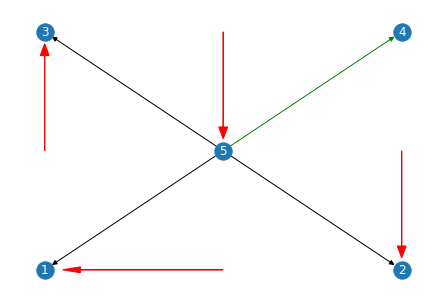

In [2]:
n = 5
G = nx.DiGraph()
G.add_edges_from([(n, i) for i in range(1, n)])

pos={i + 1: np.array([(-1) ** (i + 1), (-1)**(i<2)]) for i in range(n-1)}
pos[n] = np.array([0, 0])
nx.draw(G, pos, with_labels=True, font_color="white", edge_color=["k"]*(n-2) + ["g"])
plt.arrow(0, 1, 0, -.8, head_width=0.05, head_length=0.1, width=0, color="r")
plt.arrow(-1, 0, 0, .8, head_width=0.05, head_length=0.1, width=0, color="r")
plt.arrow(1, 0, 0, -.8, head_width=0.05, head_length=0.1, width=0, color="r")
plt.arrow(0, -1, -.8, 0, head_width=0.05, head_length=0.1, width=0, color="r")
plt.show()

$\frac{d}{dt}x = Ax + Bu$  
$u = -Kx$  
$\frac{d}{dt}x = (A - BK)x$  
$x_{t+1}- x_T = (A - BK)(x_{t+1} - x_{T})$  
 - $x_{t} = [x_{t}^1,x_{t}^2, ... ,x_{t}^n]$ state at time $t$  
 - $x_{0}$ initial state
 - $x_{T}$ desired state at time $T$

$A = \begin{bmatrix}
0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 0
\end{bmatrix} 
B = \begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$

## _Dummy_ solution
Without any advance control theory, we can get a network defiend by an adjacency matrix $A$ and controlers defined by a matrix $B$ into any state. The signal sent by the $u$ propagates through the network, by using $u_{1} = [0,0,0,x_T^{4}]$ and $u_{2} = [x_T^{1},x_T^{2},x_T^{3},x_T^{5}]$ we can _cook_ any state we wish. 

## _Place_ $A-BK$ into some non-positive eigen values

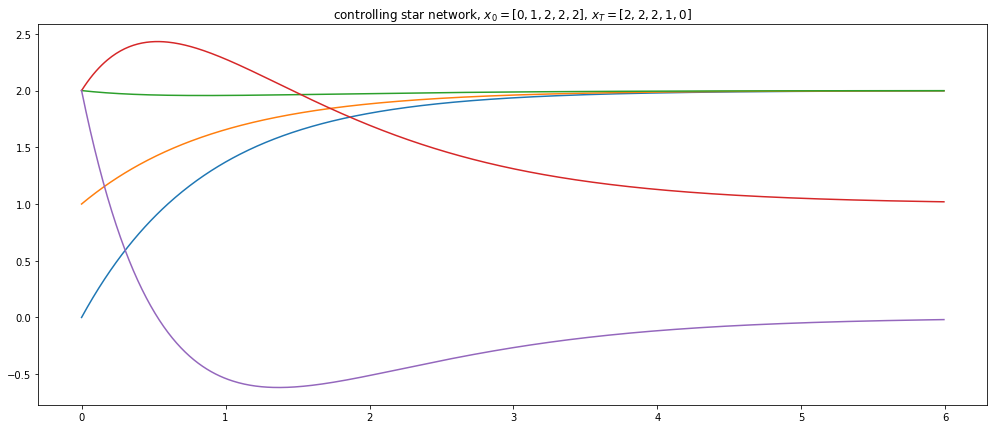

In [3]:
# Some non-positive eigen values to "place" matrix (A-BK) to
eigs = np.array([-1, -1.1, -1.2, -1.3, -1.4])

A = np.array([[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]])
B = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0], [0, 0, 0, 1]])
K = control.place(A, B, eigs)

x0 = np.array([0, 1, 2, 2, 2])
xT = np.array([2, 2, 2, 1, 0])

def star_network(x, t, K):
    return np.dot((A - np.dot(B, K)), (x - xT))

t = np.arange(0, 6, 0.01)
solution = odeint(star_network, x0, t, args=(K, ))

plt.figure(figsize=(17, 7))
plt.title(f"controlling star network, $x_0={list(x0)}$, $x_T={list(xT)}$")
plt.plot(t, solution)
plt.show()

## Kalman filter

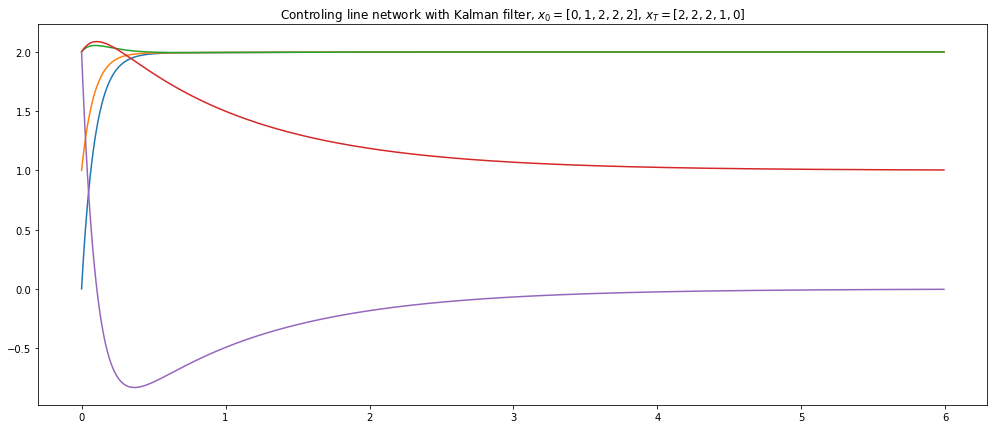

In [4]:
# Design LQR controller
Q = np.eye(n)
R = np.eye(n - 1) *.01
K, S, E = control.lqr(A, B, Q, R)

t = np.arange(0, 6, 0.01)
solution = odeint(star_network, x0, t, args=(K, ))

plt.figure(figsize=(17, 7))
plt.title(f"Controling line network with Kalman filter, $x_0={list(x0)}$, $x_T={list(xT)}$")
plt.plot(t, solution)
plt.show()

In [5]:
def pentanary2decimal(state: np.array) -> int:
    num = "".join([str(int(a)) for a in state])
    return int(num, 5)

def decimal2pentanary(num: int) -> np.array:
    res = np.zeros(4)
    i = 0
    while num > 0:
        res[-(i + 1)] = num % 5
        num = num // 5
        i += 1
    return res

assert pentanary2decimal(np.array([1,2,3,4])) == 194
assert (decimal2pentanary(194) == np.array([1,2,3,4])).all()

In [19]:
q = {}

epsilon = 0.05
gamma = 0.999
alpha = 0.5

desired_state_pentanary = pentanary2decimal(xT)

def episode(max_iter=20, halt=False):
    def model(_s, _a):
        u = decimal2pentanary(_a)
        return (np.dot(A, _s) + np.dot(B, u))
        
    state = x0
    action = 0
    i = 0
    history = [state]
    while (i < max_iter):
        state_pentanary = pentanary2decimal(state)
        
        if np.random.rand() < epsilon:
            # Explore strategy
            best_a = np.random.randint(3**4)
            
        else:
            # Exploit strategy
            q_max = -1
            best_a = -1
            for a in range(3**4):
                temp_state = model(state, a)
                if 3 in decimal2pentanary(a) or 4 in decimal2pentanary(a):
                    continue
                
                temp_state_pentanary = pentanary2decimal(temp_state)
                if q.get((temp_state_pentanary, a), 0.1) > q_max:
                    q_max = q.get((temp_state_pentanary, a), 0.01)
                    best_a = a
            
        temp_state = model(state, best_a)
        if 3 in decimal2pentanary(best_a) or 4 in decimal2pentanary(best_a):
            continue
        temp_state_pentanary = pentanary2decimal(temp_state)
        q_max = q.get((temp_state_pentanary, best_a), 0.01)
        
        reward = (temp_state_pentanary == desired_state_pentanary) * 1
        q_current = q.get((state_pentanary, action), 0.01)
        q[(state_pentanary, action)] = min(q_current + alpha * (reward + gamma * q_max - q_current), 1)
        
        state = temp_state
        action = best_a
        i += 1
        history.append(state)
        if reward and halt:
            return history
        
    return history

In [20]:
for e in range(10000):
    episode()

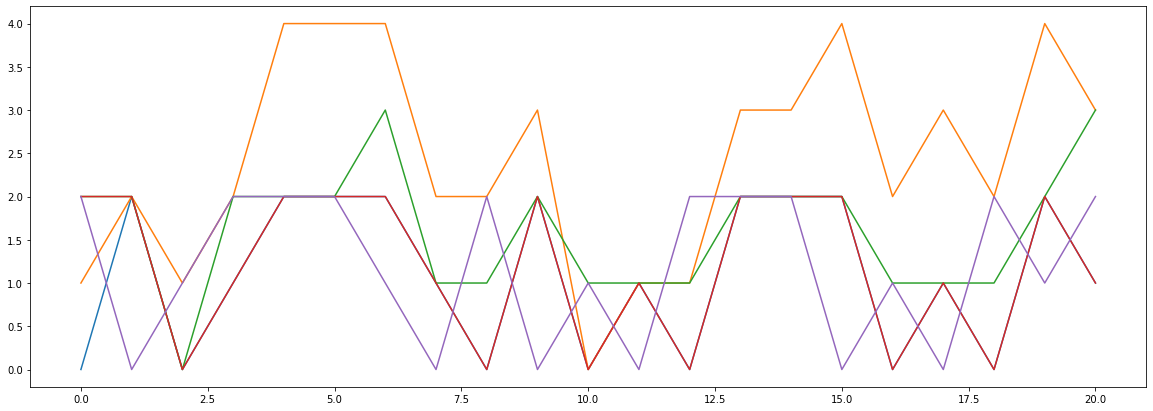

In [21]:
plt.figure(figsize=(20, 7))
plt.plot(episode(halt=True))
plt.show()

In [18]:
q

{(187, 0): 0.0011857285235574873,
 (1862, 62): 0.0011858081471545008,
 (1861, 61): 0.0011863859604781457,
 (1082, 62): 0.001186748732812579,
 (1860, 60): 0.0011861497994265732,
 (302, 62): 0.0011866773792659018,
 (1837, 57): 0.0011866930368948261,
 (1836, 56): 0.001186573526980621,
 (1081, 61): 0.00118603937084681,
 (1080, 60): 0.0011866836569132833,
 (301, 61): 0.0011866506535070322,
 (1057, 57): 0.0011862861397433132,
 (1835, 55): 0.0011862462596068297,
 (300, 60): 0.0011862645701985154,
 (277, 57): 0.0011866576382293607,
 (1812, 52): 0.0011860206287322545,
 (1811, 51): 0.0011862552558864635,
 (1056, 56): 0.0011864689162433876,
 (1055, 55): 0.001186532641601568,
 (276, 56): 0.0011862106142995809,
 (1032, 52): 0.0011861992495564144,
 (1810, 50): 0.001186379209095732,
 (275, 55): 0.0011863828418367287,
 (252, 52): 0.0011865368160198422,
 (1737, 37): 0.0011862037793771668,
 (1736, 36): 0.00118618585165656,
 (1031, 51): 0.0011866913692208905,
 (1030, 50): 0.0011862120165963448,
 (251, 51

## References
[1] Brunton, S., & Kutz, J. (2019). _Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control._ Cambridge: Cambridge University Press. doi:10.1017/9781108380690  
[2] Brunton, S, (2017). _Linear Quadratic Regulator (LQR) Control for the Inverted Pendulum on a Cart [Control Bootcamp]_, https://www.youtube.com/watch?v=1_UobILf3cc  
[3] Sutton, R. S. & Barto, A. G. (2018 ), _Reinforcement Learning: An Introduction_, The MIT Press.  
[4] Liu, Y. Y. & Barabasi, A. L. (2016), _Control Principes of Complex Networks_, 10.1103/RevModPhys.88.035006  